In [1]:
%pip install openpyxl

Rendement Annualisé: 2.35%
Rendement Cumulé: 18.72%
Valeur Finale: 11,871.92€
Valeur Finale Après Impôt: 11,310.35€
Durée de l'Investissement: 7.14 ans


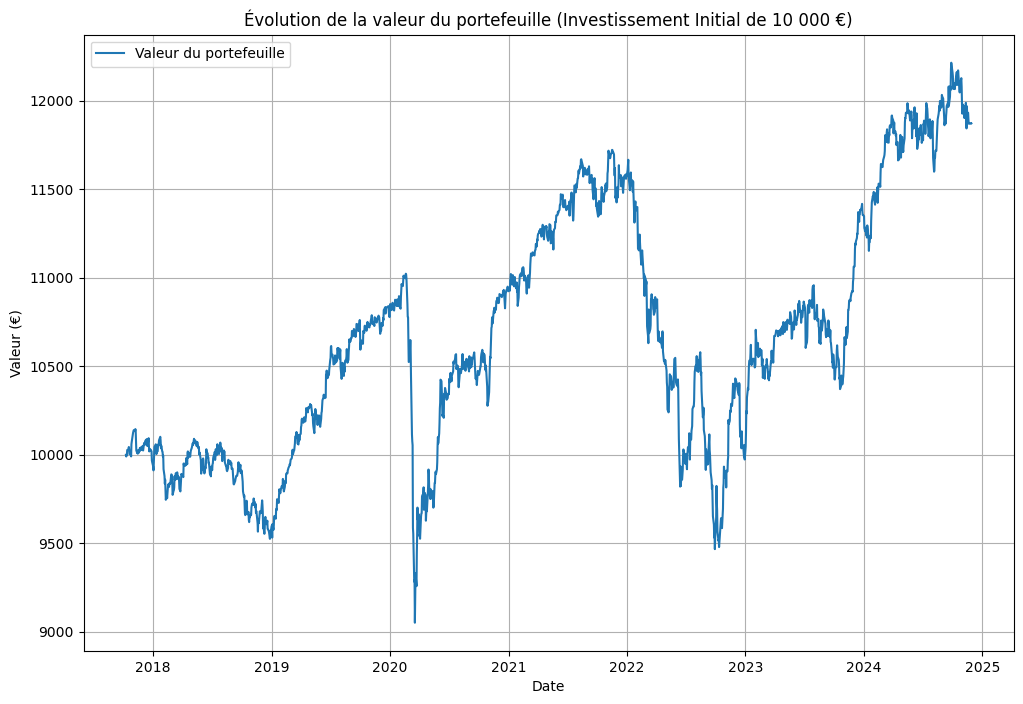

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les fichiers
df_gov_bond = pd.read_excel("Historique VL Euro Gov Bond.xlsx")
df_stoxx50 = pd.read_excel("HistoricalData EuroStoxx 50.xlsx")
df_pimco = pd.read_excel("PIMCO Euro Short-Term High Yield Corporate Bond Index UCITS ETF (EUHA).xlsx")

# Convertir les colonnes de dates au format datetime
df_gov_bond['Date'] = pd.to_datetime(df_gov_bond['Date'], errors='coerce', dayfirst=True)
df_stoxx50['Date'] = pd.to_datetime(df_stoxx50['Date'], errors='coerce', dayfirst=True)
df_pimco['Date'] = pd.to_datetime(df_pimco['Date'], errors='coerce', dayfirst=True)

# Supprimer les lignes avec des dates invalides
df_gov_bond = df_gov_bond.dropna(subset=['Date'])
df_stoxx50 = df_stoxx50.dropna(subset=['Date'])
df_pimco = df_pimco.dropna(subset=['Date'])

# Renommer les colonnes de valeur liquidative
df_gov_bond.rename(columns={'NAV': 'VL_Gov_Bond'}, inplace=True)
df_stoxx50.rename(columns={'NAV': 'VL_Stoxx50'}, inplace=True)
df_pimco.rename(columns={'NAV': 'VL_PIMCO_Short_Term'}, inplace=True)

# Trier les fichiers par ordre chronologique (du plus ancien au plus récent)
start_date = pd.to_datetime("2017-10-09")
df_gov_bond = df_gov_bond[df_gov_bond['Date'] >= start_date].sort_values(by='Date', ascending=True).reset_index(drop=True)
df_stoxx50 = df_stoxx50[df_stoxx50['Date'] >= start_date].sort_values(by='Date', ascending=True).reset_index(drop=True)
df_pimco = df_pimco[df_pimco['Date'] >= start_date].sort_values(by='Date', ascending=True).reset_index(drop=True)

# Fusionner les DataFrames sur la colonne 'Date'
df_combined = pd.merge(df_gov_bond[['Date', 'VL_Gov_Bond']],
                       df_stoxx50[['Date', 'VL_Stoxx50']],
                       on='Date', how='outer')

df_combined = pd.merge(df_combined,
                       df_pimco[['Date', 'VL_PIMCO_Short_Term']],
                       on='Date', how='outer').sort_values(by='Date', ascending=True).reset_index(drop=True)

# Interpolation pour combler les valeurs manquantes
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns
df_combined[numeric_cols] = df_combined[numeric_cols].interpolate(method='linear', axis=0)

# Frais courants (exprimés en pourcentage annuel)
frais = {
    'VL_Gov_Bond': 0.15,         # 0.15% pour Euro Gov Bond
    'VL_Stoxx50': 0.09,          # 0.09% pour Euro STOXX 50
    'VL_PIMCO_Short_Term': 0.50  # 0.50% pour PIMCO Short Term
}

# Appliquer les frais sur les VL
def apply_fees(df, frais):
    """
    Ajuste les VL pour prendre en compte les frais courants.
    Les frais sont appliqués quotidiennement sur une base annuelle.
    """
    days_in_year = 365.25
    for col, fee in frais.items():
        if col in df.columns:
            daily_fee = (1 - fee / 100) ** (1 / days_in_year)
            df[col] = df[col] * (daily_fee ** np.arange(len(df)))
    return df

df_combined = apply_fees(df_combined, frais)

# Poids du portefeuille
weights = {
    'Gov_Bond': 0.50,
    'Stoxx50': 0.30,
    'Short_Term': 0.20
}

# Calculer la valeur du portefeuille
def calculate_portfolio_value(df, weights, initial_investment):
    """
    Calcule l'évolution de la valeur du portefeuille à partir d'un investissement initial.
    """
    df['Portfolio_Value'] = (
        weights['Gov_Bond'] * df['VL_Gov_Bond'] / df['VL_Gov_Bond'].iloc[0] +
        weights['Stoxx50'] * df['VL_Stoxx50'] / df['VL_Stoxx50'].iloc[0] +
        weights['Short_Term'] * df['VL_PIMCO_Short_Term'] / df['VL_PIMCO_Short_Term'].iloc[0]
    ) * initial_investment  # Base initiale définie par l'utilisateur
    return df

# Appliquer l'investissement initial de 10 000 €
initial_investment = 10000
df_combined = calculate_portfolio_value(df_combined, weights, initial_investment)

# Calculer le rendement annualisé, cumulatif et autres métriques
def calculate_performance(df):
    """
    Calcule les performances du portefeuille.
    """
    total_return = (df['Portfolio_Value'].iloc[-1] / initial_investment) - 1  # Rendement total
    annualized_return = (1 + total_return) ** (1 / (len(df) / 252)) - 1  # Rendement annualisé
    final_value = df['Portfolio_Value'].iloc[-1]
    gross_gain = final_value - initial_investment
    net_gain = gross_gain * 0.70  # PFU appliqué
    final_value_after_tax = initial_investment + net_gain
    num_years = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days / 365.25
    
    return {
        'Rendement Annualisé': f"{annualized_return*100:.2f}%",
        'Rendement Cumulé': f"{total_return*100:.2f}%",
        'Valeur Finale': f"{final_value:,.2f}€",
        'Valeur Finale Après Impôt': f"{final_value_after_tax:,.2f}€",
        'Durée de l\'Investissement': f"{num_years:.2f} ans"
    }

# Afficher les performances
performance = calculate_performance(df_combined)
for key, value in performance.items():
    print(f"{key}: {value}")

# Visualiser l'évolution du portefeuille
plt.figure(figsize=(12, 8))
plt.plot(df_combined['Date'], df_combined['Portfolio_Value'], label='Valeur du portefeuille')
plt.title("Évolution de la valeur du portefeuille (Investissement Initial de 10 000 €)")
plt.xlabel("Date")
plt.ylabel("Valeur (€)")
plt.legend()
plt.grid(True)
plt.show()

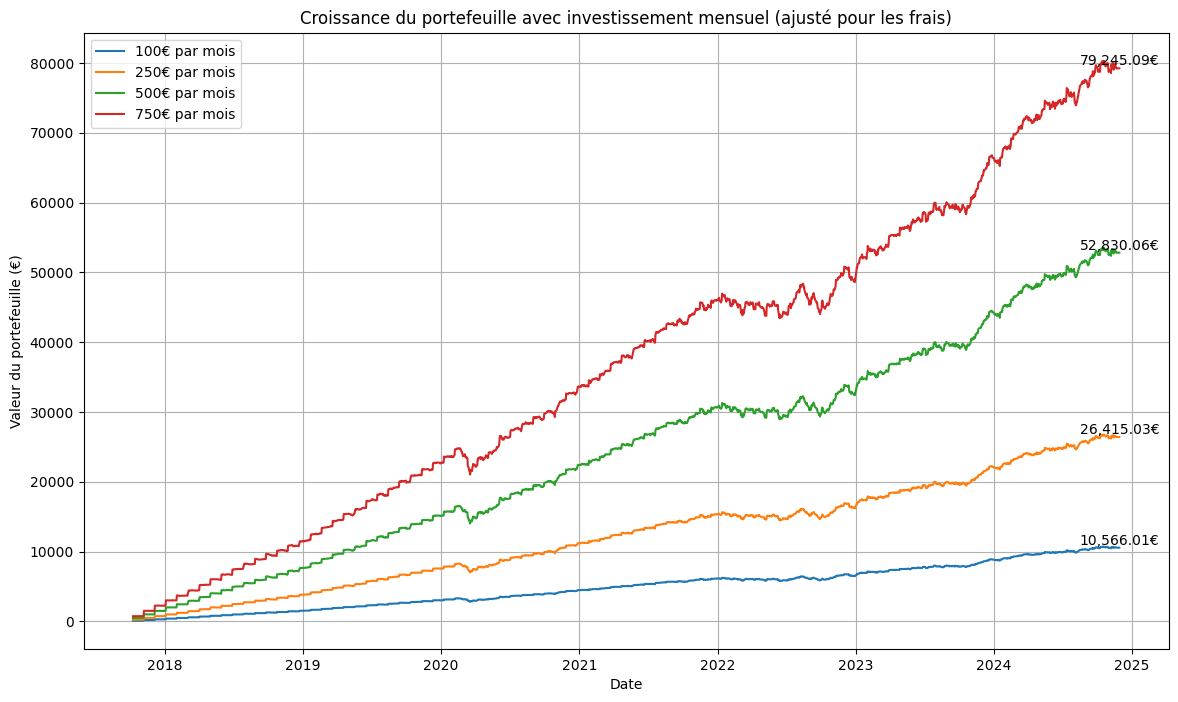

  Investissement Mensuel Rendement Annualisé Rendement Cumulé Valeur Finale  \
0                   100€               2.35%           18.72%    10,566.01€   
1                   250€               2.35%           18.72%    26,415.03€   
2                   500€               2.35%           18.72%    52,830.06€   
3                   750€               2.35%           18.72%    79,245.09€   

  Valeur Finale Après Impôt Durée de l'Investissement  
0                10,066.21€                  7.14 ans  
1                25,165.52€                  7.14 ans  
2                50,331.04€                  7.14 ans  
3                75,496.56€                  7.14 ans  


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les fichiers
df_gov_bond = pd.read_excel("Historique VL Euro Gov Bond.xlsx")
df_stoxx50 = pd.read_excel("HistoricalData EuroStoxx 50.xlsx")
df_pimco = pd.read_excel("PIMCO Euro Short-Term High Yield Corporate Bond Index UCITS ETF (EUHA).xlsx")

# Convertir les colonnes de dates au format datetime
df_gov_bond['Date'] = pd.to_datetime(df_gov_bond['Date'], errors='coerce', dayfirst=True)
df_stoxx50['Date'] = pd.to_datetime(df_stoxx50['Date'], errors='coerce', dayfirst=True)
df_pimco['Date'] = pd.to_datetime(df_pimco['Date'], errors='coerce', dayfirst=True)

# Supprimer les lignes avec des dates invalides
df_gov_bond = df_gov_bond.dropna(subset=['Date'])
df_stoxx50 = df_stoxx50.dropna(subset=['Date'])
df_pimco = df_pimco.dropna(subset=['Date'])

# Renommer les colonnes de valeur liquidative
df_gov_bond.rename(columns={'NAV': 'VL_Gov_Bond'}, inplace=True)
df_stoxx50.rename(columns={'NAV': 'VL_Stoxx50'}, inplace=True)
df_pimco.rename(columns={'NAV': 'VL_PIMCO_Short_Term'}, inplace=True)

# Trier les fichiers par ordre chronologique (du plus ancien au plus récent)
start_date = pd.to_datetime("2017-10-09")
df_gov_bond = df_gov_bond[df_gov_bond['Date'] >= start_date].sort_values(by='Date', ascending=True).reset_index(drop=True)
df_stoxx50 = df_stoxx50[df_stoxx50['Date'] >= start_date].sort_values(by='Date', ascending=True).reset_index(drop=True)
df_pimco = df_pimco[df_pimco['Date'] >= start_date].sort_values(by='Date', ascending=True).reset_index(drop=True)

# Fusionner les DataFrames sur la colonne 'Date'
df_combined = pd.merge(df_gov_bond[['Date', 'VL_Gov_Bond']],
                       df_stoxx50[['Date', 'VL_Stoxx50']],
                       on='Date', how='outer')

df_combined = pd.merge(df_combined,
                       df_pimco[['Date', 'VL_PIMCO_Short_Term']],
                       on='Date', how='outer').sort_values(by='Date', ascending=True).reset_index(drop=True)

# Interpolation pour combler les valeurs manquantes
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns
df_combined[numeric_cols] = df_combined[numeric_cols].interpolate(method='linear', axis=0)

# Frais courants (exprimés en pourcentage annuel)
frais = {
    'VL_Gov_Bond': 0.15,         # 0.15% pour Euro Gov Bond
    'VL_Stoxx50': 0.09,          # 0.09% pour Euro STOXX 50
    'VL_PIMCO_Short_Term': 0.50  # 0.50% pour PIMCO Short Term
}

# Appliquer les frais sur les VL
def apply_fees(df, frais):
    """
    Ajuste les VL pour prendre en compte les frais courants.
    Les frais sont appliqués quotidiennement sur une base annuelle.
    """
    days_in_year = 365.25
    for col, fee in frais.items():
        if col in df.columns:
            daily_fee = (1 - fee / 100) ** (1 / days_in_year)
            df[col] = df[col] * (daily_fee ** np.arange(len(df)))
    return df

df_combined = apply_fees(df_combined, frais)

# Poids du portefeuille
weights = {
    'Gov_Bond': 0.50,
    'Stoxx50': 0.30,
    'Short_Term': 0.20
}

# Calculer la valeur du portefeuille
def calculate_portfolio_value(df, weights):
    df['Portfolio_Value'] = (
        weights['Gov_Bond'] * df['VL_Gov_Bond'] / df['VL_Gov_Bond'].iloc[0] +
        weights['Stoxx50'] * df['VL_Stoxx50'] / df['VL_Stoxx50'].iloc[0] +
        weights['Short_Term'] * df['VL_PIMCO_Short_Term'] / df['VL_PIMCO_Short_Term'].iloc[0]
    ) * 100  # Base initiale de 100€
    return df

df_combined = calculate_portfolio_value(df_combined, weights)

# Simulation d'investissement mensuel
def simulate_monthly_investment(df, monthly_investments):
    """
    Simule l'investissement mensuel et retourne les données pour chaque montant.
    """
    results = {}
    for investment in monthly_investments:
        total_capital = 0
        portfolio_value = []
        capital_cumulative = []
        interests_cumulative = []
        
        for i, row in df.iterrows():
            if i % 21 == 0:  # Approximativement un mois (21 jours ouvrés)
                total_capital += investment
            capital_cumulative.append(total_capital)
            portfolio_current_value = row['Portfolio_Value'] * (total_capital / 100)  # Ajusté par la base initiale
            portfolio_value.append(portfolio_current_value)
            interests_cumulative.append(portfolio_current_value - total_capital)
        
        # Sauvegarder les résultats pour ce montant d'investissement
        results[investment] = {
            'Portfolio': portfolio_value,
            'Capital': capital_cumulative,
            'Interests': interests_cumulative
        }
    
    return results

# Exécution de la simulation
monthly_investments = [100, 250, 500, 750]
simulation_results = simulate_monthly_investment(df_combined, monthly_investments)

# Calculer la performance annualisée et cumulée
def calculate_performance(df, results):
    performance_table = []
    for investment, data in results.items():
        total_return = (data['Portfolio'][-1] / data['Capital'][-1]) - 1  # Performance cumulée
        annualized_return = (1 + total_return) ** (1 / (len(df) / 252)) - 1  # Rendement annualisé
        
        # Ajouter les valeurs finales : Montant final, capital et intérêts
        final_value = data['Portfolio'][-1]
        final_capital = data['Capital'][-1]
        final_interests = data['Interests'][-1]
        
        # Application de la fiscalité (PFU 30%) sur la plus-value
        gross_gain = final_interests
        net_gain = gross_gain * 0.70  # Après application du PFU à 30%
        final_value_after_tax = final_value - gross_gain + net_gain

        # Nombre d'années de l'investissement
        num_years = (pd.to_datetime("2024-11-30") - pd.to_datetime("2017-10-09")).days / 365.25
        
        performance_table.append([
            f"{investment}€", 
            f"{annualized_return*100:.2f}%", 
            f"{total_return*100:.2f}%",
            f"{final_value:,.2f}€",
            f"{final_value_after_tax:,.2f}€",  # Montant final après fiscalité
            f"{num_years:.2f} ans"
        ])
    return pd.DataFrame(performance_table, columns=[
        'Investissement Mensuel', 
        'Rendement Annualisé', 
        'Rendement Cumulé', 
        'Valeur Finale', 
        'Valeur Finale Après Impôt', 
        'Durée de l\'Investissement'
    ])

performance_df = calculate_performance(df_combined, simulation_results)

# Afficher la courbe d'évolution du portefeuille
plt.figure(figsize=(14, 8))
for investment, data in simulation_results.items():
    plt.plot(df_combined['Date'], data['Portfolio'], label=f'{investment}€ par mois')
    plt.text(df_combined['Date'].iloc[-1], data['Portfolio'][-1], f'{data["Portfolio"][-1]:,.2f}€', 
             color='black', ha='center', va='bottom', fontsize=10)

plt.title("Croissance du portefeuille avec investissement mensuel (ajusté pour les frais)")
plt.xlabel("Date")
plt.ylabel("Valeur du portefeuille (€)")
plt.legend()
plt.grid(True)
plt.show()

# Afficher le tableau des performances
print(performance_df)